In [24]:
from lxml import etree
from lxml.etree import tostring, parse
import wikitextparser as wtp
import pandas as pd
import re
import networkx as nx
import mwparserfromhell 
from annoy import AnnoyIndex
from sentence_transformers import SentenceTransformer,util
import torch
import os
import matplotlib.pyplot as plt
from functools import reduce

# Graph et similarité entre les textes

In [2]:
import bz2
import subprocess

In [3]:
data_path = 'enwiki-20201001-pages-articles1.xml-p1p41242.bz2'

In [4]:
lines = []
for i, line in enumerate(bz2.BZ2File(data_path, 'r')):
    lines.append(line)
    if i > 5e5:
        break

In [5]:
import xml.sax

class WikiXmlHandler(xml.sax.handler.ContentHandler):
    """Content handler for Wiki XML data using SAX"""
    def __init__(self):
        xml.sax.handler.ContentHandler.__init__(self)
        self._buffer = None
        self._values = {}
        self._current_tag = None
        self._pages = []

    def characters(self, content):
        """Characters between opening and closing tags"""
        if self._current_tag:
            self._buffer.append(content)

    def startElement(self, name, attrs):
        """Opening tag of element"""
        if name in ('title', 'text'):
            self._current_tag = name
            self._buffer = []

    def endElement(self, name):
        """Closing tag of element"""
        if name == self._current_tag:
            self._values[name] = ' '.join(self._buffer)

        if name == 'page':
            if "disambiguation" not in self._values['text']:
                self._pages.append((self._values['title'], self._values['text']))

In [6]:
# Content handler for Wiki XML
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

handler._pages

[]

In [7]:
# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for line in bz2.BZ2File(data_path, 'r'):
    parser.feed(line)

    if len(handler._pages) > 1000:
        break

## Node links - Graph

In [8]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

In [9]:
node_a = []
node_b = []
ids = []

ids_articles = []
article_name = []
text_article = []

i = 1
k = 1

for p in handler._pages:
    chosen_page = p
    wiki = mwparserfromhell.parse(chosen_page[1])
    
    ids_articles.append(k)
    k+=1
    article_name.append(chosen_page[0])
    
    tr = wiki.strip_code().strip()
    cleaned_text = cleanhtml(tr)

    text_article.append(cleaned_text.split("\n")[0])
    
    wikilinks = [x.title for x in wiki.filter_wikilinks()]
    if wikilinks != []:
        for wik in wikilinks:
            ids.append(i)
            node_a.append(chosen_page[0])
            node_b.append(str(wik))
        i += len(wikilinks)

In [10]:
dict_articles = {"ID_Article": ids, "Name_article" : node_a, "Outgoing_links" : node_b}
links_nodes = pd.DataFrame(data = dict_articles) 

In [11]:
links_nodes.tail()

,ID_Article,Name_article,Outgoing_links
176751,176338,Analgesic,Congenital insensitivity to pain
176752,176338,Analgesic,Category:Analgesics
176753,176338,Analgesic,Category:Pain
176754,176338,Analgesic,Category:Opioids
176755,176338,Analgesic,Category:Agnosia


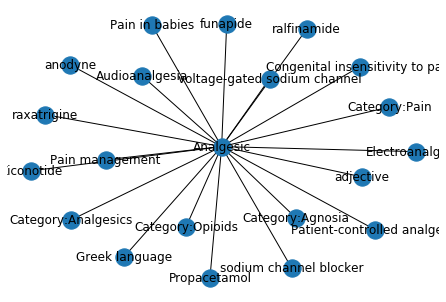

In [15]:
g = nx.from_pandas_edgelist(links_nodes[-20:], source='Name_article', target='Outgoing_links') 
nx.draw(g, with_labels=True)
plt.savefig("exemple_graph_articles.png")
plt.show()

## Text Similarity

Je vais utiliser le premier paragraphe pour calculer la similarité entre les documents. Autrement, j'aurais beaucoup trop de caractères spéciaux qui, malgré le preprocessing effectuées auparavant, n'ont pas tous été supprimés.

In [16]:
dict_texts = {"ID_Article": ids_articles, "Name_article" : article_name, "Text_article" : text_article}
text_articles = pd.DataFrame(data = dict_texts) 

In [17]:
text_articles.tail()

,ID_Article,Name_article,Text_article
996,997,Antipope John XXIII,Baldassarre Cossa (c. 1370 – 22 December 1419)...
997,998,Antonio Salieri,thumb|upright|Portrait of Salieri by Joseph Wi...
998,999,Cobble Hill Tunnel,The Cobble Hill Tunnel (also known as the Atla...
999,1000,Annapolis Valley,The Annapolis Valley is a valley and region in...
1000,1001,Analgesic,An analgesic or painkiller is any member of th...


In [18]:
def store_data(data, name_output = "articles_encoding.ann"):
    
    model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

    f = 768
    t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
    
    for i, row in data.iterrows():
        text_art = row["Text_article"]
        if len(text_art.split(" ")) > 10:
            try:

                v = model.encode(text_art)
                t.add_item(row["ID_Article"], v)

            except:

                print(text_art)

    t.build(10) # 10 trees
    t.save(name_output)

    print("Done")

In [19]:
store_data(text_articles)

Done


In [20]:
def load_corpus(file_name):
    f = 768
    u = AnnoyIndex(f, 'angular')
    u.load(file_name)
    return u

def import_enc(file_name = "articles_encoding.ann"):
    model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
    embeddings = load_corpus(file_name)
    return(model, embeddings)

def produce_prediction(query_text, model, embeddings, top_n = 3):
    query = model.encode(query_text)
    nearest = embeddings.get_nns_by_vector(query, top_n, include_distances = True)
    return nearest

In [21]:
model, embeddings = import_enc()

In [25]:
pred = produce_prediction("The Annapolis Valley is a valley and region in the Canadian province of Nova Scotia. It is located in the western part of the Nova Scotia peninsula, formed by a trough between two parallel mountain ranges along the shore of the Bay of Fundy. Statistics Canada defines the Annapolis Valley as an economic region, composed of Annapolis County, Kings County, and Hants County. ", model, embeddings)

pred_df = reduce(pd.DataFrame.append, map(lambda i: text_articles[text_articles.ID_Article == i], pred[0]))
pred_df

,ID_Article,Name_article,Text_article
999,1000,Annapolis Valley,The Annapolis Valley is a valley and region in...
309,310,Aalborg Municipality,Aalborg Municipality is a municipality (Danish...
459,460,Park Güell,The Park Güell ( ; ) is a public park system c...
